In [17]:
# Required for DADVI experiments, running TAVIE and other BBVI algorithms
import pymc as pm
import pytensor
import pytensor.tensor as pt
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import jax
import jax.numpy as jnp
setattr(jnp, "product", jnp.prod)
jax.config.update("jax_enable_x64", True)
from CompetingMethods import *
from dadvi.pymc.jax_api import fit_pymc_dadvi_with_jax
from TAVIE import *
import rich
from sklearn.preprocessing import scale
from IPython.display import display, Latex
from time import perf_counter
from tqdm import tqdm, trange
from scipy.stats import t
import arviz as az
import re

In [18]:
# Required imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from itertools import product
from IPython.display import display, HTML

In [19]:
def smart_fmt_single_setting(x):
    if x is None:
        return "--"
    try:
        return f"{float(x):.3e}"
    except (ValueError, TypeError):
        return "--"


def metrics_summary_single_setting(metric_dict, metrics, methods, settings):
    """
    Build a compact summary for the single-setting case.

    Returns: dict keyed as "{metric}_{method}_{setting_value}" -> [mean, min, max]
    Example key: "mse_beta_TAVIE_1000"
    """
    if len(settings) != 1:
        raise ValueError("metrics_summary_single_setting expects exactly one setting.")
    sval = settings[0]

    res = {}
    for metric, method in product(metrics, methods):
        dict_key = f"{metric}_{method}"
        # For single setting, metric_dict[dict_key] should be an array-like of repetitions
        arr = np.asarray(metric_dict[dict_key], dtype=float).ravel()
        mu, mn, mx = np.nanmedian(arr), np.nanpercentile(arr, 25), np.nanpercentile(arr, 75)
        res[f"{metric}_{method}_{sval}"] = [mu, mn, mx]
    return res

# ---------- HTML table (rows = methods, cols = metrics) ----------
def build_html_table_single_setting(summary,
                                    metrics, metric_display,
                                    methods, method_display):
    """
    Returns a DataFrame whose index = method display names and columns = metric display names.
    Each cell contains HTML with mean on top and (min, max) below.
    """
    # Infer the single setting value from any key in the summary
    if not summary:
        raise ValueError("Empty summary passed to build_html_table_single_setting.")
    # Pull one key and parse the trailing setting token
    example_key = next(iter(summary))
    sval = example_key.split("_")[-1]

    rows = []
    for meth_id, meth_disp in zip(methods, method_display):
        cell_vals = {}
        for met_id, met_disp in zip(metrics, metric_display):
            key = f"{met_id}_{meth_id}_{sval}"
            if key in summary:
                mu, mn, mx = summary[key]
                cell_vals[met_disp] = (
                    f"{smart_fmt_single_setting(mu)}"
                    f"<br>({smart_fmt_single_setting(mn)}, {smart_fmt_single_setting(mx)})"
                )
            else:
                cell_vals[met_disp] = "--"
        rows.append((meth_disp, cell_vals))

    df = pd.DataFrame.from_dict(dict(rows), orient="index")
    df.index.name = "Methods"
    # Nice HTML display (line breaks inside cells)
    display(HTML(df.to_html(escape=False)))
    return df  # also return the DataFrame if you need to style further


def to_latex_single_setting(summary,
                            metrics, metric_display,
                            methods, method_display,
                            caption=None, label="tab:single-setting",
                            fontsize="\\small", arraystretch=1.1):
    """
    Longtable where:
      - Column 1: Methods
      - Columns 2..K: metrics (each cell shows mean with min/max beneath via \\makecell)
    Required LaTeX packages: longtable, booktabs, makecell
    """
    if not summary:
        raise ValueError("Empty summary passed to to_latex_single_setting.")

    # Column spec: one left col for methods, then centered metric columns
    k = len(metrics)
    colspec = "l" + "c" * k

    if caption is None:
        caption = "Results by method."

    # Header rows
    head_top = []
    head_top.append("\\toprule")
    metric_head = " & ".join(metric_display)
    head_top.append(f"Methods & {metric_head} \\\\")
    head_top.append("\\midrule")
    head_repeat = head_top.copy()

    # Footer rows
    foot_mid = ["\\midrule",
                f"\\multicolumn{{{1+k}}}{{r}}{{Continued on next page}} \\\\",
                "\\midrule"]
    foot_last = ["\\bottomrule"]

    # Build table lines
    lines = []
    lines.append("% Required packages: \\usepackage{longtable,booktabs,makecell}")
    if fontsize:
        lines.append(f"{{{fontsize}")
    lines.append(f"\\renewcommand{{\\arraystretch}}{{{arraystretch}}}%")
    lines.append(f"\\begin{{longtable}}{{{colspec}}}")
    lines.append(f"\\caption{{{caption}}} \\label{{{label}}} \\\\")
    lines.extend(head_top)
    lines.append("\\endfirsthead")
    lines.extend(head_repeat)
    lines.append("\\endhead")
    lines.extend(foot_mid)
    lines.append("\\endfoot")
    lines.extend(foot_last)
    lines.append("\\endlastfoot")

    # Get the single setting value from any key
    sval = next(iter(summary)).split("_")[-1]

    # Body: each row = method, cells = metrics
    for meth_id, meth_disp in zip(methods, method_display):
        cells = []
        for met_id in metrics:
            key = f"{met_id}_{meth_id}_{sval}"
            if key in summary:
                mu, mn, mx = summary[key]
                cells.append(
                    f"\\makecell[c]{{{smart_fmt_single_setting(mu)}\\\\"
                    f"({smart_fmt_single_setting(mn)}, {smart_fmt_single_setting(mx)})}}"
                )
            else:
                cells.append("--")
        lines.append(meth_disp + " & " + " & ".join(cells) + " \\\\")

    lines.append("\\end{longtable}")
    if fontsize:
        lines.append("}")

    return "\n".join(lines)


In [20]:
def smart_fmt(x):
    if x is None:
        return "--"
    try:
        return f"{float(x):.3e}"
    except (ValueError, TypeError):
        return "--"


def metrics_summary(metric_dict, metrics, methods, settings):
    """Build dict {metric_method_setting: [mean, min, max]} from raw metric_dict."""
    setting_no = range(len(settings))
    res_dict = {}
    for metric, method, setting in product(metrics, methods, setting_no):
        dict_key = f"{metric}_{method}"
        if len(settings) == 1:
            temp = metric_dict[dict_key]
        else:
            temp = metric_dict[dict_key][setting]
            arr = np.asarray(temp, dtype=float).ravel()
            mu, mn, mx = np.nanmedian(arr), np.nanpercentile(arr, 25), np.nanpercentile(arr, 75)
        res_dict[f"{metric}_{method}_{settings[setting]}"] = [mu, mn, mx]
    return res_dict

# ---------- Simple HTML display table (unchanged) ----------
def build_tables_from_summary(summary, metrics, metric_display, methods, method_display,
                              settings, settings_name="n", for_latex=False):
    rows = []
    for metric, metric_disp in zip(metrics, metric_display):
        for method, method_disp in zip(methods, method_display):
            cell_vals = {}
            for n in settings:
                key = f"{metric}_{method}_{n}"
                if key in summary:
                    mu, mn, mx = summary[key]
                    if for_latex:
                        # we'll ignore this for LaTeX now (we generate LaTeX manually)
                        cell_vals[n] = f"{smart_fmt(mu)}\\\\({smart_fmt(mn)}, {smart_fmt(mx)})"
                    else:
                        cell_vals[n] = f"{smart_fmt(mu)}<br>({smart_fmt(mn)}, {smart_fmt(mx)})"
                else:
                    cell_vals[n] = "--"
            rows.append(((metric_disp, method_disp), cell_vals))
    df = pd.DataFrame.from_dict(dict(rows), orient="index")
    df.index = pd.MultiIndex.from_tuples(df.index, names=["Metric", "Method"])
    df = df[settings]  # enforce column order
    df.columns.name = settings_name
    display(HTML(df.to_html(escape=False)))
    return df

# ---------- CLEAN LaTeX generator (manual; tidy) ----------
def to_latex_from_summary_clean(summary,
                                metrics, metric_display,
                                methods, method_display,
                                settings, settings_name="n",
                                caption=None, label="tab:mean-range",
                                fontsize="\\small", arraystretch=1.15):
    """
    Generates a clean longtable:
      - First column: Metric (multirow over methods)
      - Second column: Method
      - Remaining columns: settings values
      - Each data cell uses \\makecell[r]{mean\\(min, max)} for stacked lines
    Requires LaTeX packages: longtable, booktabs, multirow, makecell
    """
    k = len(settings)
    # Column format: Metric (l), Method (l), then k right-aligned numeric columns
    colspec = "ll" + "c" * k

    # Caption default
    if caption is None:
        n_list = ", ".join(map(str, settings))
        caption = rf"Mean and range across repetitions; columns are {settings_name} $\in\{{{n_list}\}}$."

    # Header (appears at table top and on continued pages)
    head_top = []
    head_top.append("\\toprule")
    # First header row: blank over Metric/Method headers then the settings values
    settings_head = " & ".join(str(s) for s in settings)
    head_top.append(f" &  & \\multicolumn{{{k}}}{{c}}{{{settings_name}}} \\\\")
    head_top.append("\\cmidrule(lr){" + f"3-{2+k}" + "}")
    head_top.append(f"Metric & Method & {settings_head} \\\\")
    head_top.append("\\midrule")

    head_repeat = head_top.copy()
    head_repeat[0] = "\\toprule"  # same styling on new pages

    # Footer on continued pages
    foot_mid = ["\\midrule",
                f"\\multicolumn{{{2+k}}}{{r}}{{Continued on next page}} \\\\",
                "\\midrule"]
    foot_last = ["\\bottomrule"]

    # Begin building table
    lines = []
    lines.append("% Required packages: \\usepackage{longtable,booktabs,multirow,makecell}")
    if fontsize:
        lines.append(f"{{{fontsize}")
    lines.append(f"\\renewcommand{{\\arraystretch}}{{{arraystretch}}}%")
    lines.append(f"\\begin{{longtable}}{{{colspec}}}")
    lines.append(f"\\caption{{{caption}}} \\label{{{label}}}\\\\")
    lines.extend(head_top)
    lines.append("\\endfirsthead")
    lines.extend(head_repeat)
    lines.append("\\endhead")
    lines.extend(foot_mid)
    lines.append("\\endfoot")
    lines.extend(foot_last)
    lines.append("\\endlastfoot")

    # Body: for each metric group, multirow across the number of methods
    for m_disp, m_id in zip(metric_display, metrics):
        group_rows = []
        for meth_disp, meth_id in zip(method_display, methods):
            cells = []
            for n in settings:
                key = f"{m_id}_{meth_id}_{n}"
                if key in summary:
                    mu, mn, mx = summary[key]
                    cells.append(f"\\makecell[c]{{{smart_fmt(mu)}\\\\({smart_fmt(mn)}, {smart_fmt(mx)})}}")
                else:
                    cells.append("--")
            group_rows.append((meth_disp, cells))

        # Write first row with \multirow{len(methods)}{*}{Metric}
        first_meth, first_cells = group_rows[0]
        lines.append(f"\\multirow{{{len(group_rows)}}}{{*}}{{{m_disp}}} & {first_meth} & " +
                     " & ".join(first_cells) + " \\\\")
        # Remaining methods in the group
        for meth_disp, cells in group_rows[1:]:
            lines.append(f" & {meth_disp} & " + " & ".join(cells) + " \\\\")
        # Add a little breathing room between groups
        lines.append("\\hline")

    lines.append("\\end{longtable}")
    if fontsize:
        lines.append("}")  # close font size group

    latex_code = "\n".join(lines)
    return latex_code

# alpha simulation runs for Student's-t 

In [21]:
# ==== Experiment settings ====
p = 8
tau2_true = 3.0
df = 5
num_reps = 100
n = 2000
alphas = [0.2, 0.4, 0.6, 0.8, 0.95, 1.00]

# True beta vector
beta_true = np.random.normal(loc=0.0, scale=1.0, size=p+1)

# Prior for full‐cov BBVI
#Sigma_prior = np.eye(p + 1)
#a, b = 0.025, 0.025

# Pre‐allocate storage: shape (len(alpha_sizes), num_reps)
alpha_sizes = len(alphas)
mse_beta_TAVIE  = np.zeros((alpha_sizes, num_reps))
mse_tau2_TAVIE  = np.zeros((alpha_sizes, num_reps))
time_TAVIE      = np.zeros((alpha_sizes, num_reps))

# Initialize TAVIE once
student_tavie_model = TAVIE_loc_scale(family="student", fit_intercept=True)

# ==== Main loops ====
for i, alpha in enumerate(alphas):
    for rep in trange(num_reps, desc=f"alpha={alpha}"):
        np.random.seed(rep)
        # Generate synthetic data
        X = np.random.normal(size=(n, p))
        #X_bbvi = np.column_stack((np.ones(n), X))
        error =  np.random.standard_t(size = n, df = df) * 1/np.sqrt(tau2_true)
        y = beta_true[0] + X @ beta_true[1:len(beta_true)] + error

        # ---- TAVIE ----
        t0 = perf_counter()
        student_tavie_model.fit(X, y, nu=df, alpha=alpha, verbose=False)
        time_TAVIE[i, rep] = perf_counter() - t0
        beta_est_TAVIE, tau2_est_TAVIE = student_tavie_model.get_TAVIE_means(verbose=False)
        mse_beta_TAVIE[i, rep] = np.mean((beta_est_TAVIE - beta_true)**2)
        mse_tau2_TAVIE[i, rep] = (tau2_est_TAVIE - tau2_true)**2
        
        
# saving the metrics
import pickle

# collect everything into a single dict
metrics_df = {
    'p'            :       p,
    'n'            :       n,
    'alpha'        :       alphas,
    'mse_beta_TAVIE':     mse_beta_TAVIE,
    'mse_tau2_TAVIE':     mse_tau2_TAVIE,
    'time_TAVIE':         time_TAVIE,
}

# write to disk
with open(f'alpha_results/Student_metrics_alpha.pkl', 'wb') as f:
   pickle.dump(metrics_df, f, protocol=pickle.HIGHEST_PROTOCOL)

alpha=1.0: 100%|██████████| 100/100 [00:00<00:00, 112.89it/s]


In [22]:
path = f"alpha_results/Student_metrics_alpha.pkl"

metrics_df = pd.read_pickle(path)
alpha = metrics_df['alpha']

# =========================
# Example usage (same inputs you already have)
# =========================
metrics_dict = metrics_df
metrics = ["mse_beta", "mse_tau2", "time"]
metric_display = [r"MSE of $\beta$", r"MSE of $\tau^{2}$", "Runtime (s)"]
methods = ["TAVIE"]
method_display = ["TAVIE"]
settings = alpha
settings_name = "alpha"

summary = metrics_summary(metrics_dict, metrics, methods, settings)
build_tables_from_summary(summary, metrics, metric_display,
                                   methods, method_display, settings,
                                   settings_name=settings_name)
latex_code = to_latex_from_summary_clean(summary,
                                         metrics, metric_display,
                                         methods, method_display,
                                         settings, settings_name=settings_name,
                                         caption=r"Average metrics (mean over repetitions; range below) for Student SSG.",
                                         label="tab:mean-range",
                                         fontsize="\\scriptsize",   # tweak if needed
                                         arraystretch=1.15)
print(latex_code)

,alpha,0.2,0.4,0.6,0.8,0.95,1.0
Metric,Method,,,,,,
MSE of $\beta$,TAVIE,"2.074e-04(1.492e-04, 3.004e-04)","2.059e-04(1.474e-04, 2.786e-04)","1.993e-04(1.487e-04, 2.770e-04)","1.982e-04(1.477e-04, 2.773e-04)","1.970e-04(1.471e-04, 2.769e-04)","1.971e-04(1.470e-04, 2.770e-04)"
MSE of $\tau^{2}$,TAVIE,"1.038e-01(5.693e-02, 1.356e-01)","3.083e-02(7.879e-03, 5.140e-02)","1.704e-02(3.443e-03, 3.055e-02)","1.196e-02(2.989e-03, 2.426e-02)","1.001e-02(2.434e-03, 2.040e-02)","9.789e-03(2.427e-03, 1.951e-02)"
Runtime (s),TAVIE,"7.745e-03(7.572e-03, 7.964e-03)","8.070e-03(7.924e-03, 8.298e-03)","8.188e-03(8.110e-03, 8.357e-03)","8.262e-03(8.152e-03, 8.415e-03)","8.276e-03(8.136e-03, 8.369e-03)","8.335e-03(8.143e-03, 8.393e-03)"


% Required packages: \usepackage{longtable,booktabs,multirow,makecell}
{\scriptsize
\renewcommand{\arraystretch}{1.15}%
\begin{longtable}{llcccccc}
\caption{Average metrics (mean over repetitions; range below) for Student SSG.} \label{tab:mean-range}\\
\toprule
 &  & \multicolumn{6}{c}{alpha} \\
\cmidrule(lr){3-8}
Metric & Method & 0.2 & 0.4 & 0.6 & 0.8 & 0.95 & 1.0 \\
\midrule
\endfirsthead
\toprule
 &  & \multicolumn{6}{c}{alpha} \\
\cmidrule(lr){3-8}
Metric & Method & 0.2 & 0.4 & 0.6 & 0.8 & 0.95 & 1.0 \\
\midrule
\endhead
\midrule
\multicolumn{8}{r}{Continued on next page} \\
\midrule
\endfoot
\bottomrule
\endlastfoot
\multirow{1}{*}{MSE of $\beta$} & TAVIE & \makecell[c]{2.074e-04\\(1.492e-04, 3.004e-04)} & \makecell[c]{2.059e-04\\(1.474e-04, 2.786e-04)} & \makecell[c]{1.993e-04\\(1.487e-04, 2.770e-04)} & \makecell[c]{1.982e-04\\(1.477e-04, 2.773e-04)} & \makecell[c]{1.970e-04\\(1.471e-04, 2.769e-04)} & \makecell[c]{1.971e-04\\(1.470e-04, 2.770e-04)} \\
\hline
\multirow{1}{*}{MSE 

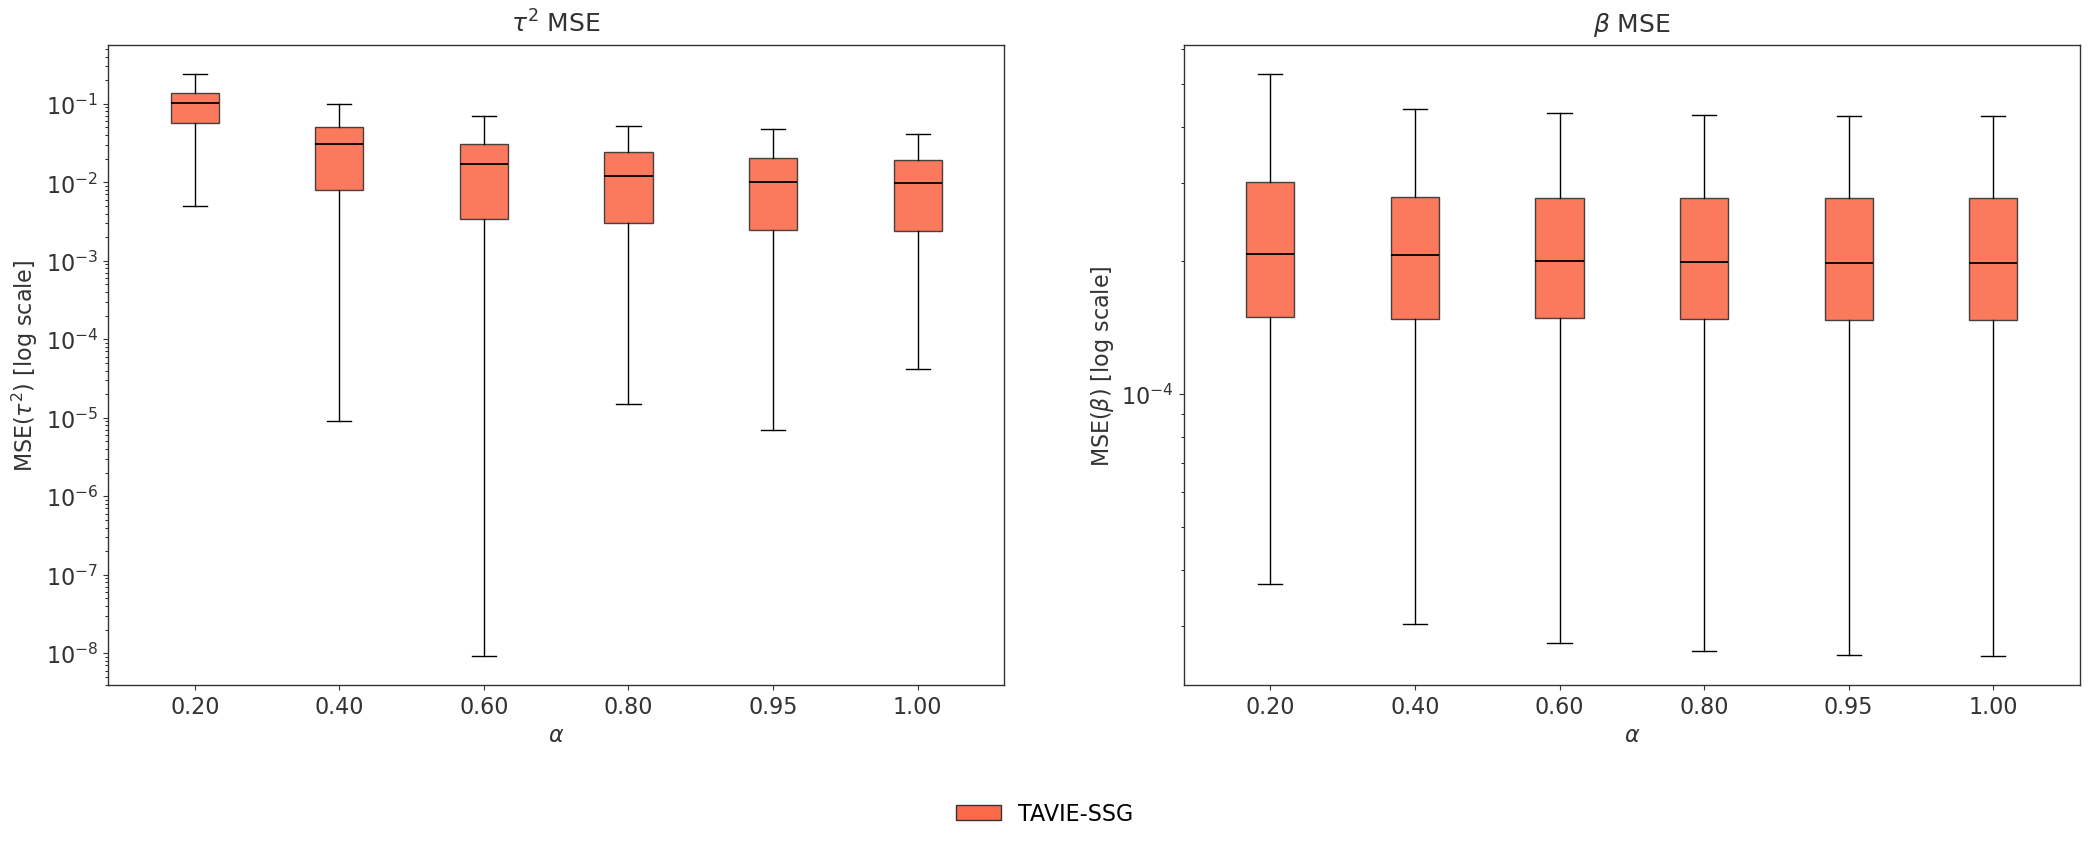

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# ------------------------------------------------
# Assumes you already have:
#   alphas            -> list of alpha values
#   mse_tau2_TAVIE    -> shape (len(alphas), num_reps)
#   mse_beta_TAVIE    -> shape (len(alphas), num_reps)
# ------------------------------------------------

methods  = ['TAVIE-SSG']

# color palette (single method -> single color)
colors = [
    '#fb6a4a'  # vivid coral
]

alpha_sizes  = len(alphas)

# --- spacing controls ---
M             = len(methods)
group_spacing = 2.4     # gap between alpha-groups on the x-axis
method_step   = 0.33    # separation between methods within each group
box_width     = 0.80    # visual width of each box
centers       = np.arange(alpha_sizes) * group_spacing  # group centers for each alpha

fig, axes = plt.subplots(1, 2, figsize=(21, 8), facecolor='white')
median_kws = dict(color='black', linewidth=1.3)

# global style for axes
for ax in axes:
    ax.set_facecolor('white')
    for spine in ax.spines.values():
        spine.set_color('#333333')
        spine.set_linewidth(1.0)
    ax.tick_params(axis='both', colors='#333333', labelsize=16)
    # ax.grid(True, color='#DDDDDD', linestyle='--', linewidth=0.7, alpha=0.9)

# ---------- 1) τ² MSE (log scale) ----------
ax = axes[0]
tau2_arrays = [
    mse_tau2_TAVIE
]

for j, arr in enumerate(tau2_arrays):
    # data for each alpha: arr[i, :] is the vector of replications at alpha_i
    data = [arr[i, :] for i in range(alpha_sizes)]
    positions = centers + (j - (M - 1) / 2) * method_step
    bp = ax.boxplot(
        data,
        positions=positions,
        widths=box_width,
        patch_artist=True,
        medianprops=median_kws,
        showfliers=False,           # often cleaner on log-scale
        whiskerprops=dict(linewidth=1.0),
        capprops=dict(linewidth=1.0)
    )
    for box in bp['boxes']:
        box.set(facecolor=colors[j], edgecolor='#333333', alpha=0.9)

ax.set_xticks(centers)
ax.set_xticklabels([f"{a:.2f}" for a in alphas], fontsize=16)  # <-- use alphas here
ax.set_yscale('log')
ax.set_xlabel(r'$\alpha$', fontsize=16, color='#333333')
ax.set_ylabel(r'MSE($\tau^2$) [log scale]', fontsize=16, color='#333333')
ax.set_title(r'$\tau^2$ MSE', fontsize=18, color='#333333', pad=10)
ax.set_xlim(centers[0] - group_spacing * 0.6, centers[-1] + group_spacing * 0.6)

# ---------- 2) β MSE (log scale) ----------
ax = axes[1]
beta_arrays = [
    mse_beta_TAVIE
]

for j, arr in enumerate(beta_arrays):
    data = [arr[i, :] for i in range(alpha_sizes)]
    positions = centers + (j - (M - 1) / 2) * method_step
    bp = ax.boxplot(
        data,
        positions=positions,
        widths=box_width,
        patch_artist=True,
        medianprops=median_kws,
        showfliers=False,
        whiskerprops=dict(linewidth=1.0),
        capprops=dict(linewidth=1.0)
    )
    for box in bp['boxes']:
        box.set(facecolor=colors[j], edgecolor='#333333', alpha=0.9)

ax.set_xticks(centers)
ax.set_xticklabels([f"{a:.2f}" for a in alphas], fontsize=16)  # <-- use alphas here
ax.set_yscale('log')
ax.set_xlabel(r'$\alpha$', fontsize=16, color='#333333')
ax.set_ylabel(r'MSE($\beta$) [log scale]', fontsize=16, color='#333333')
ax.set_title(r'$\beta$ MSE', fontsize=18, color='#333333', pad=10)
ax.set_xlim(centers[0] - group_spacing * 0.6, centers[-1] + group_spacing * 0.6)

# ---------- Common legend ----------
handles = [Patch(facecolor=colors[i], edgecolor='#333333', label=methods[i]) for i in range(M)]
fig.legend(handles=handles,
           loc='lower center',
           ncol=M,
           frameon=False,
           bbox_to_anchor=(0.5, -0.08),
           fontsize=16)

plt.tight_layout(rect=[0, 0.04, 1, 1])
plt.subplots_adjust(wspace=0.20, bottom=0.12, top=0.92)

fig.savefig(
    f'alpha_results/plots/Student_alpha_MSE_boxplots.png',
    dpi=300,
    bbox_inches='tight',
    facecolor='white'
)

plt.show()

# alpha simulation runs for Laplace

In [28]:
# ==== Experiment settings ====
p = 8
tau2_true = 3.0
num_reps = 100
alphas = [0.2, 0.4, 0.6, 0.8, 0.95, 1.00]
n = 2000

# True beta vector
beta_true = np.random.normal(loc=0.0, scale=1.0, size=p+1)

# Prior for full‐cov BBVI
# Sigma_prior = np.eye(p + 1)
# a, b = 0.025, 0.025

# Pre‐allocate storage: shape (len(sample_sizes), num_reps)
alpha_sizes = len(alphas)
mse_beta_TAVIE          = np.zeros((alpha_sizes, num_reps))
mse_tau2_TAVIE          = np.zeros((alpha_sizes, num_reps))
time_TAVIE              = np.zeros((alpha_sizes, num_reps))

# Initialize TAVIE once
laplace_tavie_model = TAVIE_loc_scale(family="laplace", fit_intercept=True)

# ==== Main loops ====
for i, alpha in enumerate(alphas):
    for rep in trange(num_reps, desc=f"alpha={alpha}"):
        np.random.seed(rep)
        # 1) Simulate data
        X = np.random.normal(size=(n, p))
        X_bbvi = np.column_stack([np.ones(n), X])
        error = np.random.laplace(loc=0.0, scale=1/np.sqrt(tau2_true), size=n)
        y = X_bbvi @ beta_true + error

        # ---- TAVIE ----
        t0 = perf_counter()
        laplace_tavie_model.fit(X, y, alpha=alpha, verbose=False)
        time_TAVIE[i, rep] = perf_counter() - t0
        beta_est_TAVIE, tau2_est_TAVIE = laplace_tavie_model.get_TAVIE_means(verbose=False)
        mse_beta_TAVIE[i, rep] = np.mean((beta_est_TAVIE - beta_true)**2)
        mse_tau2_TAVIE[i, rep] = (tau2_est_TAVIE - tau2_true)**2


# collect everything into a single dict
# saving the metrics
import pickle

# collect everything into a single dict
metrics_df = {
    'p'            :       p,
    'n'            :       n,
    'alpha'        :       alphas,
    'mse_beta_TAVIE':     mse_beta_TAVIE,
    'mse_tau2_TAVIE':     mse_tau2_TAVIE,
    'time_TAVIE':         time_TAVIE,
}

# write to disk
with open(f'alpha_results/Laplace_metrics_alpha.pkl', 'wb') as f:
   pickle.dump(metrics_df, f, protocol=pickle.HIGHEST_PROTOCOL)

alpha=1.0: 100%|██████████| 100/100 [00:02<00:00, 38.10it/s]


In [29]:
path = f"alpha_results/Laplace_metrics_alpha.pkl"

metrics_df = pd.read_pickle(path)
alpha = metrics_df['alpha']

# =========================
# Example usage (same inputs you already have)
# =========================
metrics_dict = metrics_df
metrics = ["mse_beta", "mse_tau2", "time"]
metric_display = [r"MSE of $\beta$", r"MSE of $\tau^{2}$", "Runtime (s)"]
methods = ["TAVIE"]
method_display = ["TAVIE"]
settings = alpha
settings_name = "alpha"

summary = metrics_summary(metrics_dict, metrics, methods, settings)
build_tables_from_summary(summary, metrics, metric_display,
                                   methods, method_display, settings,
                                   settings_name=settings_name)
latex_code = to_latex_from_summary_clean(summary,
                                         metrics, metric_display,
                                         methods, method_display,
                                         settings, settings_name=settings_name,
                                         caption=r"Average metrics (mean over repetitions; range below) for Laplace SSG.",
                                         label="tab:mean-range",
                                         fontsize="\\scriptsize",   # tweak if needed
                                         arraystretch=1.15)
print(latex_code)

,alpha,0.2,0.4,0.6,0.8,0.95,1.0
Metric,Method,,,,,,
MSE of $\beta$,TAVIE,"1.609e-04(1.276e-04, 2.438e-04)","1.609e-04(1.172e-04, 2.355e-04)","1.614e-04(1.181e-04, 2.377e-04)","1.627e-04(1.182e-04, 2.325e-04)","1.646e-04(1.170e-04, 2.314e-04)","1.652e-04(1.173e-04, 2.314e-04)"
MSE of $\tau^{2}$,TAVIE,"1.227e-01(8.567e-02, 1.748e-01)","3.431e-02(1.422e-02, 6.922e-02)","1.677e-02(5.419e-03, 4.202e-02)","1.291e-02(3.910e-03, 3.094e-02)","1.084e-02(2.924e-03, 2.653e-02)","1.019e-02(2.803e-03, 2.526e-02)"
Runtime (s),TAVIE,"1.651e-02(1.509e-02, 1.803e-02)","1.938e-02(1.768e-02, 2.098e-02)","2.104e-02(1.963e-02, 2.302e-02)","2.306e-02(2.059e-02, 2.528e-02)","2.405e-02(2.158e-02, 2.670e-02)","2.485e-02(2.251e-02, 2.783e-02)"


% Required packages: \usepackage{longtable,booktabs,multirow,makecell}
{\scriptsize
\renewcommand{\arraystretch}{1.15}%
\begin{longtable}{llcccccc}
\caption{Average metrics (mean over repetitions; range below) for Laplace SSG.} \label{tab:mean-range}\\
\toprule
 &  & \multicolumn{6}{c}{alpha} \\
\cmidrule(lr){3-8}
Metric & Method & 0.2 & 0.4 & 0.6 & 0.8 & 0.95 & 1.0 \\
\midrule
\endfirsthead
\toprule
 &  & \multicolumn{6}{c}{alpha} \\
\cmidrule(lr){3-8}
Metric & Method & 0.2 & 0.4 & 0.6 & 0.8 & 0.95 & 1.0 \\
\midrule
\endhead
\midrule
\multicolumn{8}{r}{Continued on next page} \\
\midrule
\endfoot
\bottomrule
\endlastfoot
\multirow{1}{*}{MSE of $\beta$} & TAVIE & \makecell[c]{1.609e-04\\(1.276e-04, 2.438e-04)} & \makecell[c]{1.609e-04\\(1.172e-04, 2.355e-04)} & \makecell[c]{1.614e-04\\(1.181e-04, 2.377e-04)} & \makecell[c]{1.627e-04\\(1.182e-04, 2.325e-04)} & \makecell[c]{1.646e-04\\(1.170e-04, 2.314e-04)} & \makecell[c]{1.652e-04\\(1.173e-04, 2.314e-04)} \\
\hline
\multirow{1}{*}{MSE 

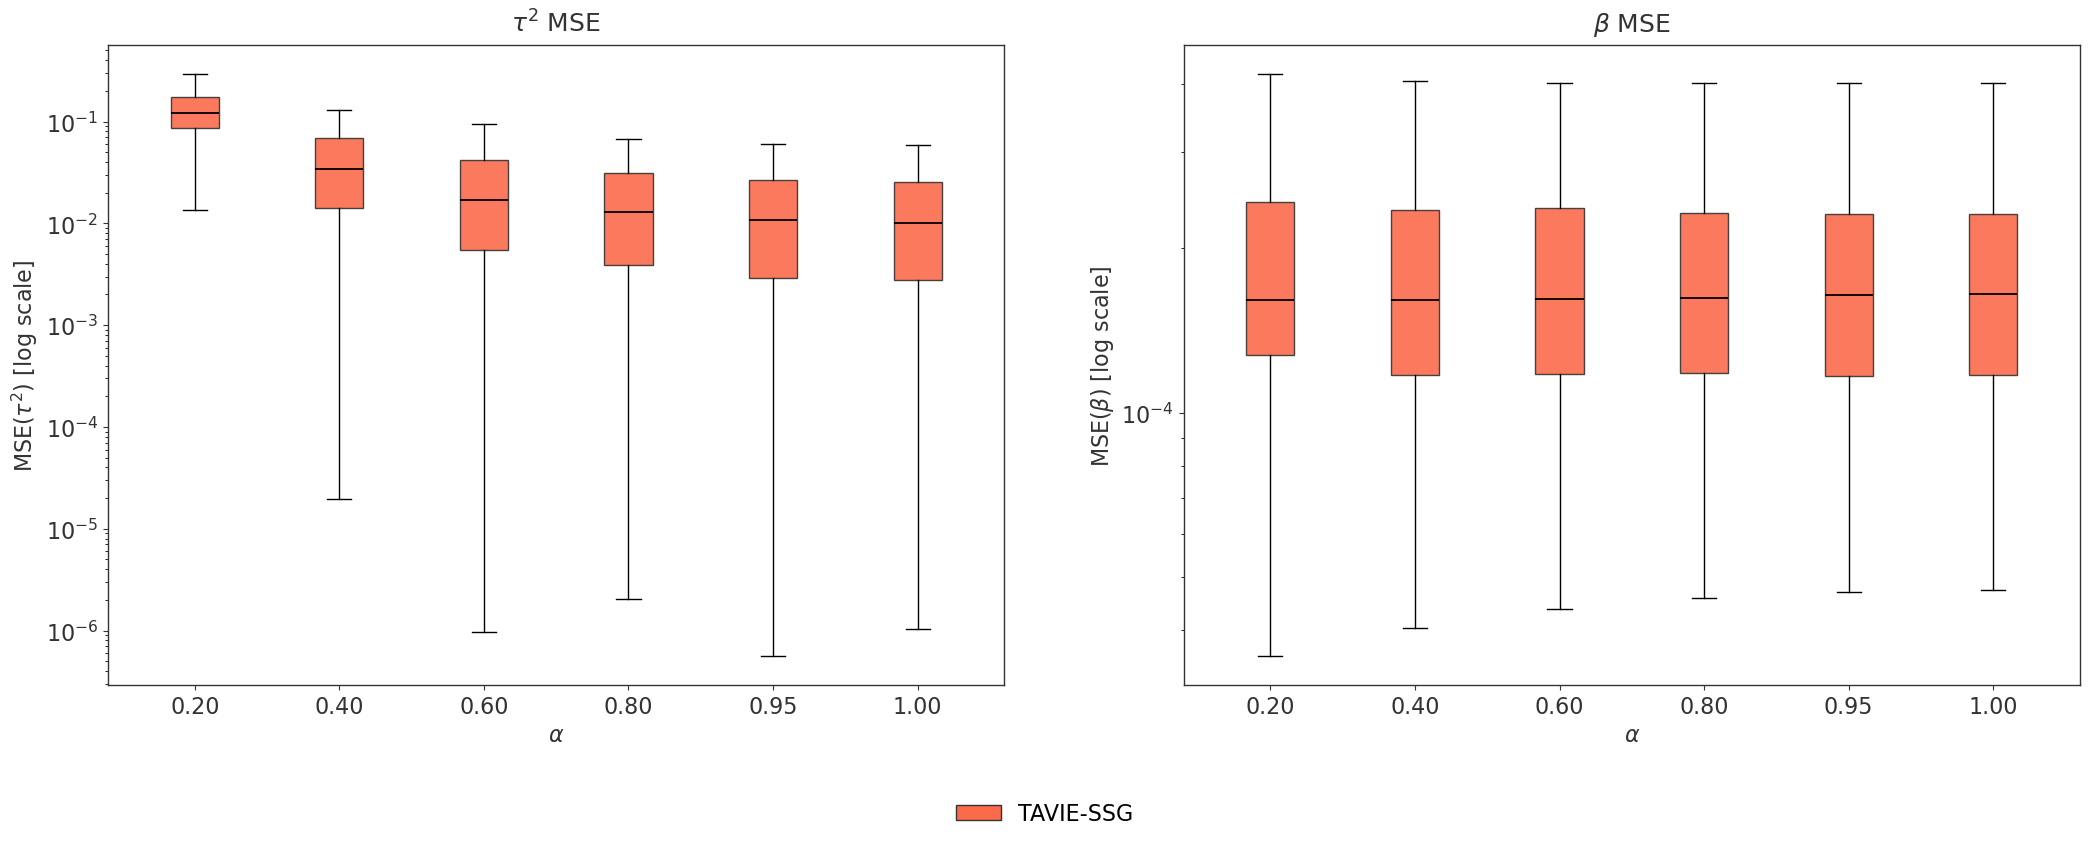

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# ------------------------------------------------
# Assumes you already have:
#   alphas            -> list of alpha values
#   mse_tau2_TAVIE    -> shape (len(alphas), num_reps)
#   mse_beta_TAVIE    -> shape (len(alphas), num_reps)
# ------------------------------------------------

methods  = ['TAVIE-SSG']

# color palette (single method -> single color)
colors = [
    '#fb6a4a'  # vivid coral
]

alpha_sizes  = len(alphas)

# --- spacing controls ---
M             = len(methods)
group_spacing = 2.4     # gap between alpha-groups on the x-axis
method_step   = 0.33    # separation between methods within each group
box_width     = 0.80    # visual width of each box
centers       = np.arange(alpha_sizes) * group_spacing  # group centers for each alpha

fig, axes = plt.subplots(1, 2, figsize=(21, 8), facecolor='white')
median_kws = dict(color='black', linewidth=1.3)

# global style for axes
for ax in axes:
    ax.set_facecolor('white')
    for spine in ax.spines.values():
        spine.set_color('#333333')
        spine.set_linewidth(1.0)
    ax.tick_params(axis='both', colors='#333333', labelsize=16)
    # ax.grid(True, color='#DDDDDD', linestyle='--', linewidth=0.7, alpha=0.9)

# ---------- 1) τ² MSE (log scale) ----------
ax = axes[0]
tau2_arrays = [
    mse_tau2_TAVIE
]

for j, arr in enumerate(tau2_arrays):
    # data for each alpha: arr[i, :] is the vector of replications at alpha_i
    data = [arr[i, :] for i in range(alpha_sizes)]
    positions = centers + (j - (M - 1) / 2) * method_step
    bp = ax.boxplot(
        data,
        positions=positions,
        widths=box_width,
        patch_artist=True,
        medianprops=median_kws,
        showfliers=False,           # often cleaner on log-scale
        whiskerprops=dict(linewidth=1.0),
        capprops=dict(linewidth=1.0)
    )
    for box in bp['boxes']:
        box.set(facecolor=colors[j], edgecolor='#333333', alpha=0.9)

ax.set_xticks(centers)
ax.set_xticklabels([f"{a:.2f}" for a in alphas], fontsize=16)  # <-- use alphas here
ax.set_yscale('log')
ax.set_xlabel(r'$\alpha$', fontsize=16, color='#333333')
ax.set_ylabel(r'MSE($\tau^2$) [log scale]', fontsize=16, color='#333333')
ax.set_title(r'$\tau^2$ MSE', fontsize=18, color='#333333', pad=10)
ax.set_xlim(centers[0] - group_spacing * 0.6, centers[-1] + group_spacing * 0.6)

# ---------- 2) β MSE (log scale) ----------
ax = axes[1]
beta_arrays = [
    mse_beta_TAVIE
]

for j, arr in enumerate(beta_arrays):
    data = [arr[i, :] for i in range(alpha_sizes)]
    positions = centers + (j - (M - 1) / 2) * method_step
    bp = ax.boxplot(
        data,
        positions=positions,
        widths=box_width,
        patch_artist=True,
        medianprops=median_kws,
        showfliers=False,
        whiskerprops=dict(linewidth=1.0),
        capprops=dict(linewidth=1.0)
    )
    for box in bp['boxes']:
        box.set(facecolor=colors[j], edgecolor='#333333', alpha=0.9)

ax.set_xticks(centers)
ax.set_xticklabels([f"{a:.2f}" for a in alphas], fontsize=16)  # <-- use alphas here
ax.set_yscale('log')
ax.set_xlabel(r'$\alpha$', fontsize=16, color='#333333')
ax.set_ylabel(r'MSE($\beta$) [log scale]', fontsize=16, color='#333333')
ax.set_title(r'$\beta$ MSE', fontsize=18, color='#333333', pad=10)
ax.set_xlim(centers[0] - group_spacing * 0.6, centers[-1] + group_spacing * 0.6)

# ---------- Common legend ----------
handles = [Patch(facecolor=colors[i], edgecolor='#333333', label=methods[i]) for i in range(M)]
fig.legend(handles=handles,
           loc='lower center',
           ncol=M,
           frameon=False,
           bbox_to_anchor=(0.5, -0.08),
           fontsize=16)

plt.tight_layout(rect=[0, 0.04, 1, 1])
plt.subplots_adjust(wspace=0.20, bottom=0.12, top=0.92)

fig.savefig(
    f'alpha_results/plots/Laplace_alpha_MSE_boxplots.png',
    dpi=300,
    bbox_inches='tight',
    facecolor='white'
)

plt.show()

# alpha simulation runs for Negative-Binomial

In [32]:
# ==== Experiment settings ====
p = 8
num_reps = 100
r = 10
alphas = [0.2, 0.4, 0.6, 0.8, 0.95, 1.00]
n = 2000

# True beta vector
beta_true = np.random.normal(loc=0.0, scale=0.5, size=p+1)

# Prior for full‐cov BBVI
# Sigma_prior = np.eye(p + 1)

# Pre‐allocate storage: shape (len(sample_sizes), num_reps)
alpha_sizes = len(alphas)
mse_beta_TAVIE          = np.zeros((alpha_sizes, num_reps))
time_TAVIE              = np.zeros((alpha_sizes, num_reps))

# TAVIE model initialization
negbin_tavie_model = TAVIE_type_II(family="negbin", fit_intercept=True)

# ==== Main loops ====
for i, alpha in enumerate(alphas):
    for rep in trange(num_reps, desc=f"alpha={alpha}"):
        np.random.seed(rep)
        # Generate synthetic data
        X = np.random.normal(size=(n, p))
        #X_bbvi = np.column_stack((np.ones(n), X))
        linear_term  = beta_true[0] + X @ beta_true[1:len(beta_true)] 
        probs = 1 / (1 + np.exp(-linear_term))
        y = np.random.negative_binomial(r, probs, size=n)

        # ---- TAVIE ----
        t0 = perf_counter()
        negbin_tavie_model.fit(X, y, r=r, alpha=alpha, verbose=False)
        time_TAVIE[i, rep] = perf_counter() - t0
        beta_est_TAVIE = negbin_tavie_model.get_TAVIE_means(verbose=False)
        mse_beta_TAVIE[i, rep] = np.mean((beta_est_TAVIE - beta_true)**2)

import pickle

# collect everything into a single dict
metrics_df = {
    'p'            :       p,
    'n'            :       n,
    'alpha'        :       alphas,
    'mse_beta_TAVIE':     mse_beta_TAVIE,
    'time_TAVIE':         time_TAVIE,
}

# write to disk
with open(f'alpha_results/NegBin_metrics_alpha.pkl', 'wb') as f:
   pickle.dump(metrics_df, f, protocol=pickle.HIGHEST_PROTOCOL)

alpha=1.0: 100%|██████████| 100/100 [00:01<00:00, 50.69it/s]


In [33]:
path = f"alpha_results/NegBin_metrics_alpha.pkl"

metrics_df = pd.read_pickle(path)
alpha = metrics_df['alpha']

# =========================
# Example usage (same inputs you already have)
# =========================
metrics_dict = metrics_df
metrics = ["mse_beta", "time"]
metric_display = [r"MSE of $\beta$", "Runtime (s)"]
methods = ["TAVIE"]
method_display = ["TAVIE"]
settings = alpha
settings_name = "alpha"

summary = metrics_summary(metrics_dict, metrics, methods, settings)
build_tables_from_summary(summary, metrics, metric_display,
                                   methods, method_display, settings,
                                   settings_name=settings_name)
latex_code = to_latex_from_summary_clean(summary,
                                         metrics, metric_display,
                                         methods, method_display,
                                         settings, settings_name=settings_name,
                                         caption=r"Average metrics (mean over repetitions; range below) for Laplace SSG.",
                                         label="tab:mean-range",
                                         fontsize="\\scriptsize",   # tweak if needed
                                         arraystretch=1.15)
print(latex_code)

,alpha,0.2,0.4,0.6,0.8,0.95,1.0
Metric,Method,,,,,,
MSE of $\beta$,TAVIE,"8.763e-05(5.344e-05, 1.245e-04)","8.802e-05(5.310e-05, 1.238e-04)","8.815e-05(5.300e-05, 1.236e-04)","8.822e-05(5.295e-05, 1.235e-04)","8.825e-05(5.292e-05, 1.234e-04)","8.826e-05(5.292e-05, 1.234e-04)"
Runtime (s),TAVIE,"1.768e-02(1.663e-02, 1.959e-02)","1.794e-02(1.670e-02, 2.031e-02)","1.874e-02(1.718e-02, 2.062e-02)","1.811e-02(1.709e-02, 2.044e-02)","1.784e-02(1.645e-02, 1.964e-02)","1.802e-02(1.699e-02, 2.014e-02)"


% Required packages: \usepackage{longtable,booktabs,multirow,makecell}
{\scriptsize
\renewcommand{\arraystretch}{1.15}%
\begin{longtable}{llcccccc}
\caption{Average metrics (mean over repetitions; range below) for Laplace SSG.} \label{tab:mean-range}\\
\toprule
 &  & \multicolumn{6}{c}{alpha} \\
\cmidrule(lr){3-8}
Metric & Method & 0.2 & 0.4 & 0.6 & 0.8 & 0.95 & 1.0 \\
\midrule
\endfirsthead
\toprule
 &  & \multicolumn{6}{c}{alpha} \\
\cmidrule(lr){3-8}
Metric & Method & 0.2 & 0.4 & 0.6 & 0.8 & 0.95 & 1.0 \\
\midrule
\endhead
\midrule
\multicolumn{8}{r}{Continued on next page} \\
\midrule
\endfoot
\bottomrule
\endlastfoot
\multirow{1}{*}{MSE of $\beta$} & TAVIE & \makecell[c]{8.763e-05\\(5.344e-05, 1.245e-04)} & \makecell[c]{8.802e-05\\(5.310e-05, 1.238e-04)} & \makecell[c]{8.815e-05\\(5.300e-05, 1.236e-04)} & \makecell[c]{8.822e-05\\(5.295e-05, 1.235e-04)} & \makecell[c]{8.825e-05\\(5.292e-05, 1.234e-04)} & \makecell[c]{8.826e-05\\(5.292e-05, 1.234e-04)} \\
\hline
\multirow{1}{*}{Runt

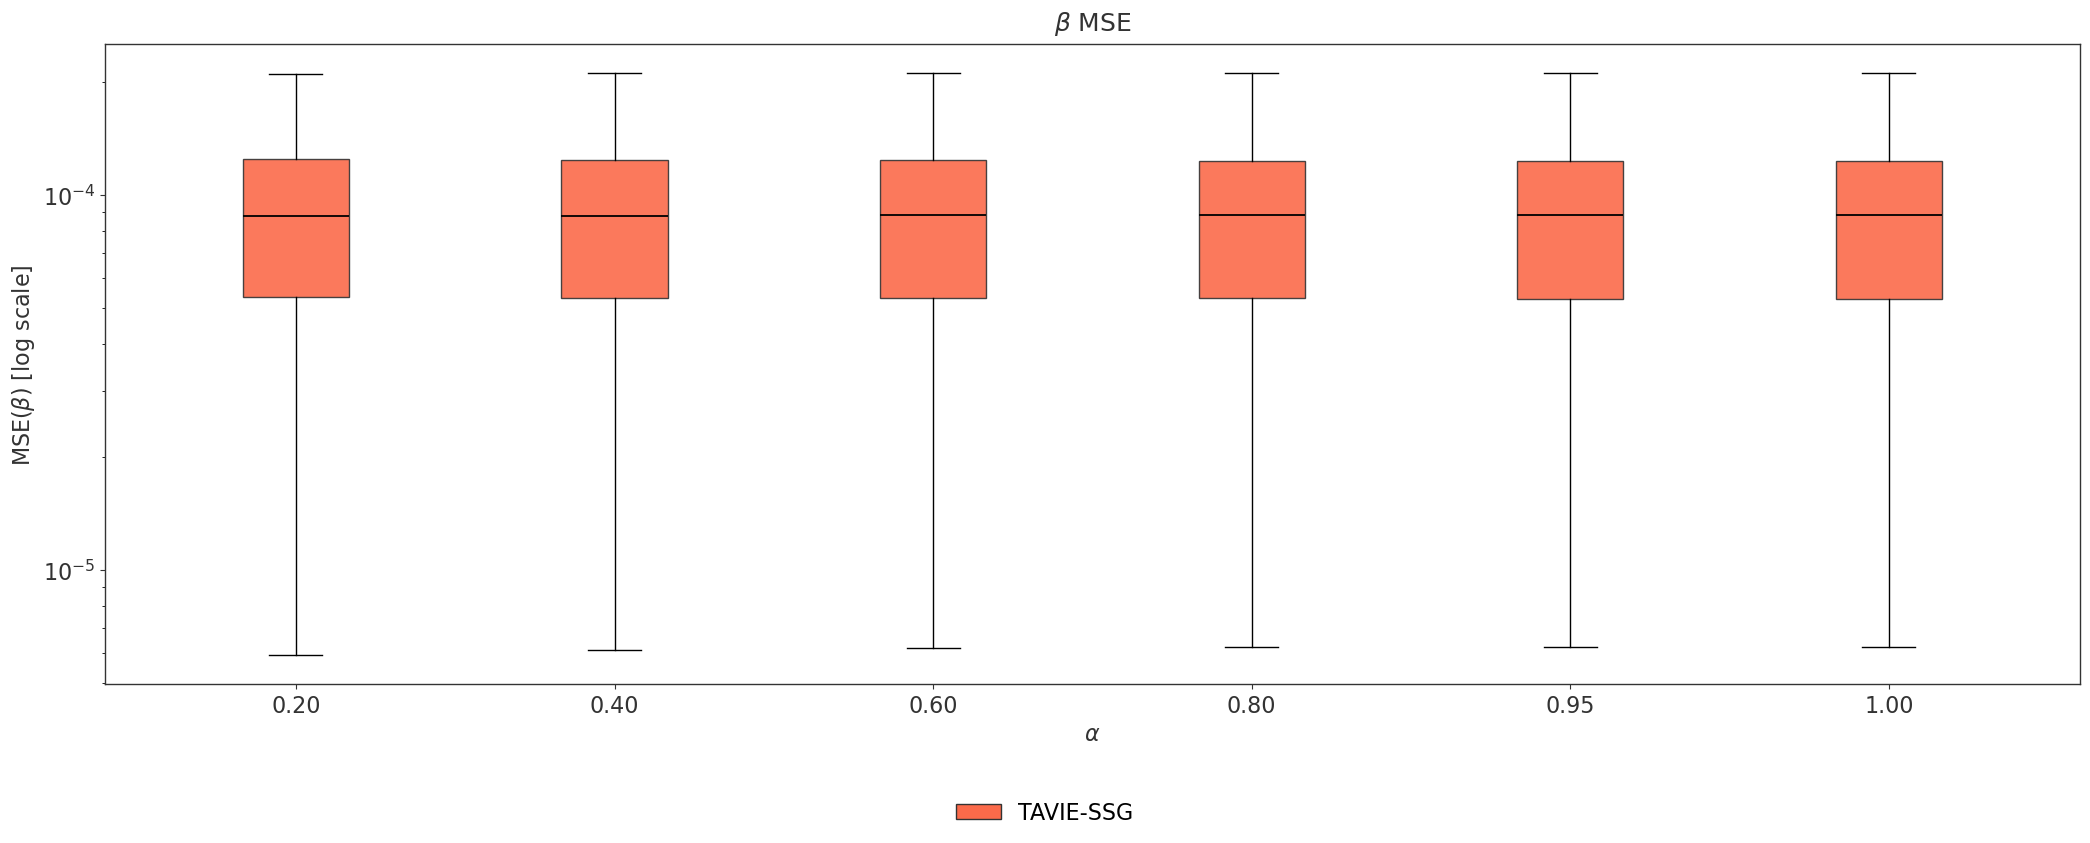

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# ------------------------------------------------
# Assumes you already have:
#   alphas            -> list of alpha values
#   mse_tau2_TAVIE    -> shape (len(alphas), num_reps)
#   mse_beta_TAVIE    -> shape (len(alphas), num_reps)
# ------------------------------------------------


methods  = ['TAVIE-SSG']

# color palette (single method -> single color)
colors = [
    '#fb6a4a'  # vivid coral
]

alpha_sizes  = len(alphas)

# --- spacing controls ---
M             = len(methods)
group_spacing = 2.4     # gap between alpha-groups on the x-axis
method_step   = 0.33    # separation between methods within each group (relevant if >1 method)
box_width     = 0.80    # visual width of each box
centers       = np.arange(alpha_sizes) * group_spacing  # group centers for each alpha

# One subplot only
fig, ax = plt.subplots(1, 1, figsize=(21, 8), facecolor='white')
median_kws = dict(color='black', linewidth=1.3)

# ----- global style for the single axis -----
ax.set_facecolor('white')
for spine in ax.spines.values():
    spine.set_color('#333333')
    spine.set_linewidth(1.0)
ax.tick_params(axis='both', colors='#333333', labelsize=16)
# ax.grid(True, color='#DDDDDD', linestyle='--', linewidth=0.7, alpha=0.9)

# ---------- β MSE (log scale) ----------
beta_arrays = [
    mse_beta_TAVIE
]

for j, arr in enumerate(beta_arrays):
    # arr[i, :] is the vector of replications at alpha_i
    data = [arr[i, :] for i in range(alpha_sizes)]
    positions = centers + (j - (M - 1) / 2) * method_step
    bp = ax.boxplot(
        data,
        positions=positions,
        widths=box_width,
        patch_artist=True,
        medianprops=median_kws,
        showfliers=False,
        whiskerprops=dict(linewidth=1.0),
        capprops=dict(linewidth=1.0)
    )
    for box in bp['boxes']:
        box.set(facecolor=colors[j], edgecolor='#333333', alpha=0.9)

ax.set_xticks(centers)
ax.set_xticklabels([f"{a:.2f}" for a in alphas], fontsize=16)
ax.set_yscale('log')
ax.set_xlabel(r'$\alpha$', fontsize=16, color='#333333')
ax.set_ylabel(r'MSE($\beta$) [log scale]', fontsize=16, color='#333333')
ax.set_title(r'$\beta$ MSE', fontsize=18, color='#333333', pad=10)
ax.set_xlim(centers[0] - group_spacing * 0.6, centers[-1] + group_spacing * 0.6)

# ---------- Common legend ----------
handles = [Patch(facecolor=colors[i], edgecolor='#333333', label=methods[i]) for i in range(M)]
fig.legend(handles=handles,
           loc='lower center',
           ncol=M,
           frameon=False,
           bbox_to_anchor=(0.5, -0.08),
           fontsize=16)

plt.tight_layout(rect=[0, 0.04, 1, 1])
plt.subplots_adjust(wspace=0.20, bottom=0.12, top=0.92)

fig.savefig(
    f'alpha_results/plots/NegBin_alpha_MSE_boxplots.png',
    dpi=300,
    bbox_inches='tight',
    facecolor='white'
)

plt.show()